In [1]:
"""
data preparation for model-based task:
    
    1. extract the data with selected features;
    2. set the rare categorical values to 'other';
    3. fit a label encoder and a one-hot encoder for new data set
"""

##==================== Package ====================##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder
import random

import pickle  # to store temporary variable



In [7]:
##==================== File-Path (fp) ====================##
## raw data (for read)
fp_train = "../../Datasets/ctr/train.csv"
fp_test  = "../../Datasets/ctr/test.csv"

## subsample training set
fp_sub_train_f = "../../Datasets/ctr/sub_train_f.csv"

fp_col_counts = "../../Datasets/ctr/col_counts"

## data after selecting features (LR_fun needed)
## and setting rare categories' value to 'other' (feature filtering)
fp_train_f = "../../Datasets/ctr/train_f.csv"
fp_test_f  = "../../Datasets/ctr/test_f.csv"

## storing encoder for labeling / one-hot encoding task
fp_lb_enc = "../../Datasets/ctr/lb_enc"
fp_oh_enc = "../../Datasets/ctr/oh_enc"


In [8]:
##==================== pre-Processing ====================##
## some simple original features is selected for dataset
'''features are used
    C1:           int,     1001, 1002, ...
    banner_pos:   int,     0,1,2,3,...
    site_domain:  object,  large set of object variables 
    site_id:      object,  large set of object variables 
    site_category:object,  large set of object variables 
    app_id:       object,  large set of object variables 
    app_category: object,  small set of object variables
    device_type:  int,     0,1,2,3,4
    device_conn_type:int,  0,1,2,3
    C14:          int,     small set of int variables
    C15:          int,     ...
    C16:          int,     ...
'''
## feature names
cols = ['C1', 
        'banner_pos', 
        'site_domain', 
        'site_id',
        'site_category',
        'app_id',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        'C15',
        'C16']

cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)


In [9]:
## data reading
df_train_ini = pd.read_csv(fp_train, nrows = 10)
df_train_org = pd.read_csv(fp_train, chunksize = 1000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  chunksize = 1000000, iterator = True)


In [10]:
#----- counting features' categories numbers -----#
## 1.init_dict
cols_counts = {}  # the categories count for each feature
for col in cols:
    cols_counts[col] = df_train_ini[col].value_counts()


In [11]:
cols_counts

{'C1': 1005    9
 1002    1
 Name: C1, dtype: int64, 'C14': 15706    2
 15704    2
 20632    1
 20362    1
 16920    1
 21689    1
 15707    1
 18993    1
 Name: C14, dtype: int64, 'C15': 320    10
 Name: C15, dtype: int64, 'C16': 50    10
 Name: C16, dtype: int64, 'app_category': 07d7df22    10
 Name: app_category, dtype: int64, 'app_id': ecad2386    10
 Name: app_id, dtype: int64, 'banner_pos': 0    8
 1    2
 Name: banner_pos, dtype: int64, 'device_conn_type': 0    8
 2    2
 Name: device_conn_type, dtype: int64, 'device_type': 1    9
 0    1
 Name: device_type, dtype: int64, 'site_category': 28905ebd    5
 f028772b    3
 50e219e0    1
 0569f928    1
 Name: site_category, dtype: int64, 'site_domain': f3845767    5
 7e091613    1
 c4e18dd6    1
 25d4cfcd    1
 bb1ef334    1
 9166c161    1
 Name: site_domain, dtype: int64, 'site_id': 1fbe01fe    5
 8fda644b    1
 fe8cc448    1
 d6137915    1
 e151e245    1
 84c7ba46    1
 Name: site_id, dtype: int64}

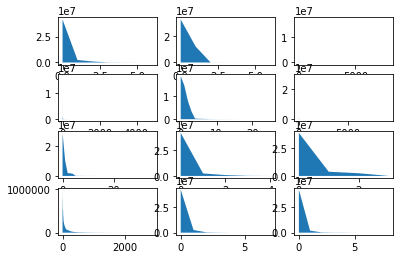

In [12]:
## 2.counting through train-set
for chunk in df_train_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())

## 3.counting through test-set
for chunk in df_test_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())
        
## 4.merge the deduplicates index in counting vectors
for col in cols:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # sort the counts
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   

## 5.store the value_counting
pickle.dump(cols_counts, open(fp_col_counts, 'wb'))

## 6.show the distribution of value_counts
fig = plt.figure(1)
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 3, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    # ax.set_title(col)
plt.show()


In [18]:
#----- set rare to 'other' -----#
# cols_counts = pickle.load(open(fp_col_counts, 'rb'))

## save at most k indices of the categorical variables
## and set the rest to 'other'
k = 99
col_index = {}
for col in cols:
    col_index[col] = cols_counts[col][0: k].index

df_train_org = pd.read_csv(fp_train, dtype = {'id': str}, chunksize = 1000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  dtype = {'id': str}, chunksize = 1000000, iterator = True)

## train set
hd_flag = True  # add column names at 1-st row
for chunk in df_train_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # assign all the rare variables as 'other'
        df.loc[~df[col].isin(col_index[col]), col] = 'other'
    with open(fp_train_f, 'a') as f:
        df.to_csv(f, columns = cols_train, header = hd_flag, index = False)
    hd_flag = False

## test set
hd_flag = True  # add column names at 1-st row
for chunk in df_test_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # assign all the rare variables as 'other'
        df.loc[~df[col].isin(col_index[col]), col] = 'other'
    with open(fp_test_f, 'a') as f:
        df.to_csv(f, columns = cols_test, header = hd_flag, index = False)      
    hd_flag = False


In [19]:
#----- generate encoder for label encoding -----#
#----- generate encoder for one-hot encoding -----#
'''
notes: here we do not apply label/one-hot transform
       as we do it later in the iteration of model training on chunks
'''
## 1.label encoding
lb_enc = {}
for col in cols:
    col_index[col] = np.append(col_index[col], 'other')

for col in cols:
    lb_enc[col] = LabelEncoder()
    lb_enc[col].fit(col_index[col])
    
## store the label encoder
pickle.dump(lb_enc, open(fp_lb_enc, 'wb'))

## 2.one-hot encoding
oh_enc = OneHotEncoder(cols)

df_train_f = pd.read_csv(fp_train_f, index_col=None, chunksize=500000, iterator=True)
df_test_f  = pd.read_csv(fp_test_f, index_col=None, chunksize=500000, iterator=True)

for chunk in df_train_f:
    oh_enc.fit(chunk)
for chunk in df_test_f:
    oh_enc.fit(chunk)
    
## store the one-hot encoder
pickle.dump(oh_enc, open(fp_oh_enc, 'wb'))


In [22]:
#----- construct of original train set (sub-sampling randomly) -----#
n = sum(1 for line in open(fp_train_f)) - 1  # total size of train data (about 46M)
s = 2000000 # desired train set size (2M)

## the 0-indexed header will not be included in the skip list
skip = sorted(random.sample(range(1, n+1), n-s)) 
df_train = pd.read_csv(fp_train_f, skiprows = skip)
df_train.columns = cols_train

## store the sub-sampling train set as .csv
df_train.to_csv(fp_sub_train_f, index=False) 

print(' - end - ')

 - end - 


In [33]:
for col in cols:
    print col,lb_enc[col].classes_

C1 ['1001' '1002' '1005' '1007' '1008' '1010' '1012' 'other']
banner_pos ['0' '1' '2' '3' '4' '5' '7' 'other']
site_domain ['08facbad' '0a4015b2' '0d3cb7be' '0dde25ec' '16a36ef3' '17d996e6'
 '1b32ed33' '1e0acfb4' '1e334bd3' '2296b5b3' '250469f8' '272c5d9d'
 '27e3c518' '28f93029' '2c5a2165' '2d235ae0' '30518255' '3f2f3819'
 '422b8953' '449497bc' '4c26e9ba' '510bd839' '5449fde7' '58a89a43'
 '5b626596' '5c9ae867' '5c9c05b7' '5dddf09e' '61eac15d' '64778742'
 '6b560cc1' '6b59f079' '6bdbd889' '6dbd48f0' '6e882918' '7256c623'
 '759d1c56' '75f9ddc3' '7687a86e' '77c8e77d' '7804dea6' '7d05db75'
 '7e091613' '7e1e7bdf' '7e3be6ba' '8025317b' '863fa89d' '8a429b45'
 '91cdcccd' '945bfb4b' '948ff336' '964a3bd1' '968765cd' '9690165f'
 '98572c79' '98acf46c' '98e6755b' '9b421927' '9b851bd8' '9cf7de2f'
 '9d54950b' '9eaf88fa' '9f448720' 'a10eb148' 'a17bde68' 'a434fa42'
 'a9bba545' 'ac5abf20' 'ace5b8fd' 'b12b9f85' 'b4598159' 'b9c4ab81'
 'bb1ef334' 'bd6d812f' 'bea33b9a' 'c1aa3c04' 'c4342784' 'c4e18dd6'
 'c7ca